

## **Project Summary**
In this project, I have utilized a sample dataset containing various attributes, and I will be applying different regression-based machine learning algorithms to develop a health insurance cost predictor

## insurance.csv (Data Dictionary)
| Column    | Data Type | Description                                                      |
|-----------|-----------|------------------------------------------------------------------|
| `age`       | int       | Age of the primary beneficiary.                                  |
| `sex`       | object    | Gender of the insurance contractor (male or female).             |
| `bmi`       | float     | Body mass index, a key indicator of body fat based on height and weight. |
| `children`  | int       | Number of dependents covered by the insurance plan.              |
| `smoker`    | object    | Indicates whether the beneficiary smokes (yes or no).            |
| `region`    | object    | The beneficiary's residential area in the US, divided into four regions. |
| `charges`   | float     | Individual medical costs billed by health insurance.             |



Importing the necessary libraries and loading the dataset

In [1]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


insurance_data_path = 'insurance.csv'
insurance = pd.read_csv(insurance_data_path)
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.924
1,18.0,male,33.770,1.0,no,Southeast,1725.5523
2,28.0,male,33.000,3.0,no,southeast,$4449.462
3,33.0,male,22.705,0.0,no,northwest,$21984.47061
4,32.0,male,28.880,0.0,no,northwest,$3866.8552


## **Pre processing**
1. dropped all na values from the dataset, the dropped rate is determined below
2. convert sex values into 2 values Male or Female
3. convert smoker column into distinct boolean values i.e. yes or no
4. clean the charges column i.e. remove unnecessary characters such as $ and convert to float, we also observe few negative values in the columns which upon further inspection can be converted to positive values 


In [5]:
insurance_filled = insurance.dropna() 

insurance_filled['region'] = insurance_filled['region'].str.lower()

FEMALE = 'female'
MALE = 'male'
sex_map = {'F': FEMALE, 'woman': FEMALE, 'man': MALE, 'M': MALE}

insurance_filled['sex'] = insurance_filled['sex'].replace(sex_map)

insurance_filled['smoker'] = (insurance_filled['smoker'] == 'yes')

insurance_filled['charges'] = insurance_filled['charges'].str.strip('$').astype('float64')

insurance_pos = insurance_filled.apply(lambda x: x.abs() if np.issubdtype(x.dtype, np.number) else x)

insurance_pos.sample(10)

<ipython-input-5-bc6b7f4b8877>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insurance_filled['region'] = insurance_filled['region'].str.lower()
<ipython-input-5-bc6b7f4b8877>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insurance_filled['sex'] = insurance_filled['sex'].replace(sex_map)
<ipython-input-5-bc6b7f4b8877>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

,age,sex,bmi,children,smoker,region,charges
121,18.0,male,23.750,0.0,False,northeast,1705.62450
695,26.0,female,40.185,0.0,False,northwest,3201.24515
38,35.0,male,36.670,1.0,True,northeast,39774.27630
1018,54.0,female,35.815,3.0,False,northwest,12495.29085
1114,23.0,male,24.510,0.0,False,northeast,2396.09590
1247,33.0,male,29.400,4.0,False,southwest,6059.17300
69,28.0,male,23.980,3.0,True,southeast,17663.14420
987,45.0,female,27.645,1.0,False,northwest,28340.18885
687,40.0,male,41.690,0.0,False,southeast,5438.74910
15,19.0,male,24.600,1.0,False,southwest,1837.23700


### number of dropped rows
as seen below the number of dropped rows from the original dataset is less than 2% hence it is feasiable to proceed, else we may need to fill the missing values with a required value/ mean or median based on the column or specific conditions, *please do note that based on datasets this may skew our results and also affect the model* 

In [8]:
na_percentage = round(1-(len(insurance_pos)/len(insurance)),3)

print (f"the percentage of dropped rows from the intial dataset : {na_percentage}")

the percentage of dropped rows from the intial dataset : 0.097


## **Feature Engineering**
In order to detrmine the co relation between columns we have used pair plots below, based on the pair plots between columns we observe that the column smoker to charges stands out with a drastic effect and will be crucial in our regression analysis 

c:\Users\mihir\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_stats\counting.py:137: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  bin_edges = np.histogram_bin_edges(vals, bins, binrange, weight)
c:\Users\mihir\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_stats\counting.py:176: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, edges = np.histogram(vals, **bin_kws, weights=weights, density=density)
c:\Users\mihir\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


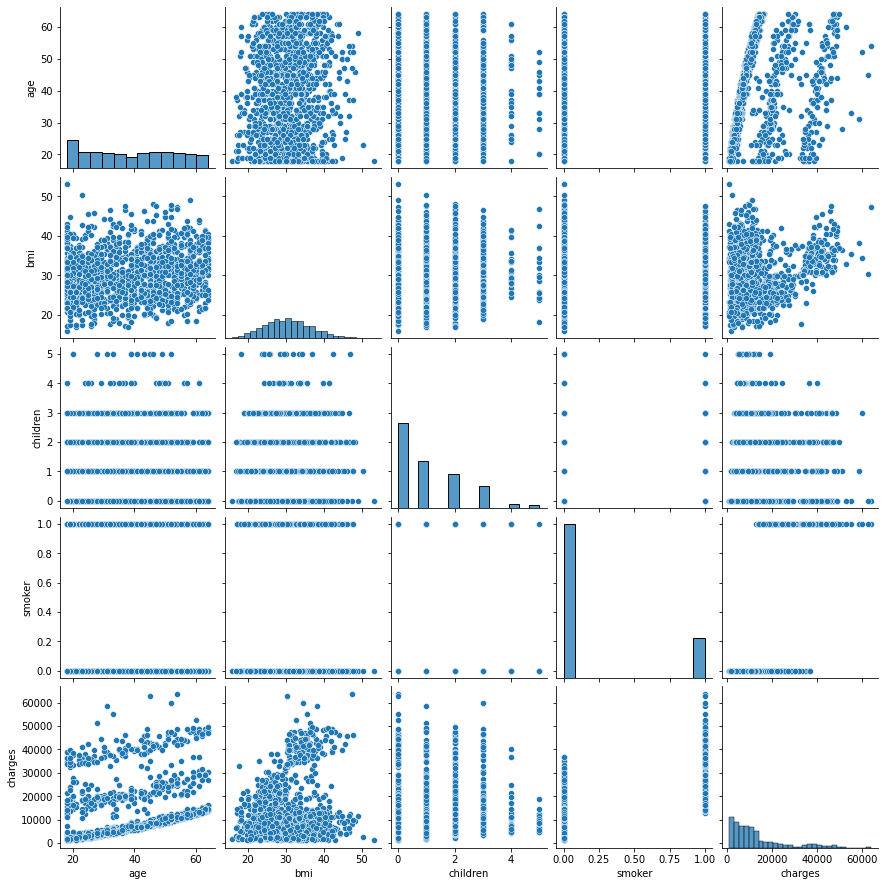

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

df = insurance_pos.copy()

sns.pairplot(df)
#plt.scatter(df['smoker'], df['charges'])


### Dummy encoding
For analysis, we transform the values within our columns into separate columns represented by 1's and 0's, typically using dummy encoding while dropping one of the categories to avoid multicollinearity. In contrast, with label encoding, we consider all the categories within a column and assign them numerical labels.
we have dummy encoded the smoker column and the sex column below

In [11]:
df_new = pd.get_dummies(df, prefix=['region'], columns=['region'])
df_new = df_new.drop(columns=['region_southeast'])

df_new['smoker'] = df_new['smoker'].astype('int64')

df_new['is_male'] = (df_new['sex'] == 'male').astype('int64')
df_new = df_new.drop(columns=['sex'])

df_new = df_new.dropna()
df_new.head()

,age,bmi,children,smoker,charges,region_northeast,region_northwest,region_southwest,is_male
0,19.0,27.900,0.0,1,16884.92400,False,False,True,0
1,18.0,33.770,1.0,0,1725.55230,False,False,False,1
2,28.0,33.000,3.0,0,4449.46200,False,False,False,1
3,33.0,22.705,0.0,0,21984.47061,False,True,False,1
4,32.0,28.880,0.0,0,3866.85520,False,True,False,1


## **Model Training** 

we will initially train with **Linear Regression** model to check the results and use R2 score and Mean Squared error to verify the results 
we observe that the R2 score is 70% which aligns with our predictions but Mean Squared error is way too high indicating deviations from actual target values 

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error 

# Define input and output variables
X = df_new.drop(columns=['charges'])
y = df_new['charges']

print(df_new.info())
print(y.info())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the R squared score
r2 = r2_score(y_test, y_pred)
mse =  mean_squared_error(y_test, y_pred)
# Output the mean squared error
print(f"R2 score : {r2}, \n Mean squared error : {mse}")

<class 'pandas.core.frame.DataFrame'>
Index: 1207 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1207 non-null   float64
 1   bmi               1207 non-null   float64
 2   children          1207 non-null   float64
 3   smoker            1207 non-null   int64  
 4   charges           1207 non-null   float64
 5   region_northeast  1207 non-null   bool   
 6   region_northwest  1207 non-null   bool   
 7   region_southwest  1207 non-null   bool   
 8   is_male           1207 non-null   int64  
dtypes: bool(3), float64(4), int64(2)
memory usage: 69.5 KB
None
<class 'pandas.core.series.Series'>
Index: 1207 entries, 0 to 1337
Series name: charges
Non-Null Count  Dtype  
--------------  -----  
1207 non-null   float64
dtypes: float64(1)
memory usage: 18.9 KB
None
R2 score : 0.7049323160872817, 
 Mean squared error : 39936613.36311095


### Validation data pre processing
we are repeating the steps on our testing data by creating a function `preprocess_df()` to perform the above steps on the validation dataset and check the results

In [14]:
def preprocess_df(df):
    df_new = pd.get_dummies(df, prefix=['region'], columns=['region'])
    df_new = df_new.drop(columns=['region_southeast'])

    df_new['smoker'] = (df_new['smoker'] == 'yes')
    df_new['smoker'] = df_new['smoker'].astype('int64')

    df_new['is_male'] = (df_new['sex'] == 'male').astype('int64')
    df_new = df_new.drop(columns=['sex'])
    
    return df_new
    

## **Data Validation**

In [15]:
val_df = pd.read_csv('validation_dataset.csv')
input_df = preprocess_df(val_df)

predictions = model.predict(input_df)

validation_data = val_df.copy()

validation_data['predicted_charges'] = predictions

validation_data.loc[validation_data['predicted_charges'] < 1000, 'predicted_charges'] = 1000

validation_data.head()



,age,sex,bmi,children,smoker,region,predicted_charges
0,18.0,female,24.090000,1.0,no,southeast,1000.000000
1,39.0,male,26.410000,0.0,yes,northeast,30956.214707
2,27.0,male,29.150000,0.0,yes,southeast,27799.409607
3,71.0,male,65.502135,13.0,yes,southeast,57194.414804
4,28.0,male,38.060000,0.0,no,southeast,6685.426312


### Observations 

we observe that although the MSE is quite high the model is able to predict the charges fairly accurately on the test data, below we will test on other models to see if we can optimize it further 

we are now going to use **Decision Tree**, **Random forest** and **Support Vector Regression** to train our models and see the results

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Support Vector Regression': SVR(kernel='rbf')
}


results = {}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
  
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)


    results[model_name] = {'R-squared': r2, 'Mean Squared Error': mse}


results_df = pd.DataFrame(results).T
print(results_df)

                           R-squared  Mean Squared Error
Linear Regression           0.704932        3.993661e+07
Decision Tree               0.683472        4.284126e+07
Random Forest               0.823530        2.388468e+07
Support Vector Regression  -0.102783        1.492587e+08


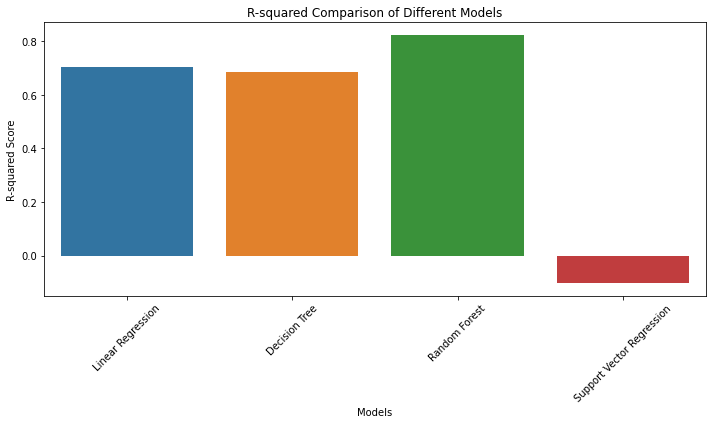

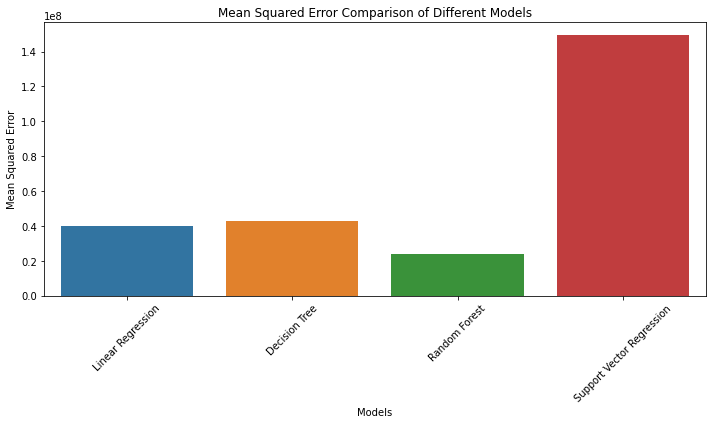

***MODEL PERFORMANCE COMPARISION*** 
                            R-squared  Mean Squared Error
Linear Regression           0.704932        3.993661e+07
Decision Tree               0.683472        4.284126e+07
Random Forest               0.823530        2.388468e+07
Support Vector Regression  -0.102783        1.492587e+08


In [32]:
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y='R-squared', data=results_df)
plt.title('R-squared Comparison of Different Models')
plt.ylabel('R-squared Score')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot for Mean Squared Error (MSE)
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y='Mean Squared Error', data=results_df)
plt.title('Mean Squared Error Comparison of Different Models')
plt.ylabel('Mean Squared Error')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"***MODEL PERFORMANCE COMPARISION*** \n {results_df}")

## Conclusion 

Form the above comparision and results we see that the **Random Forest Regressor 🏅** gives us the best results when compared to other Linear Regression, Support Vector Regression and decision tree algorithim as the **Random Forest Regressor** has the best R-Squared Score and the least Mean Squared Error 